# Analysis of the Clement-Ziza et al. 2014 RNA-seq data

### Loading in the data

In [2]:
#importing standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.multitest as smm
import warnings
#suppress warnings
warnings.filterwarnings('ignore')
%matplotlib inline  

root = '/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs'

#reading the data: /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Clement-Ziza et al 2014/Clement-Ziza processed.tsv
data = pd.read_csv(root + '/external data/Clement-Ziza et al 2014/Clement-Ziza processed.tsv', sep='\t', header=11,index_col=0)
systematic_names = data.index

### Renaming genes to their common names

In [3]:

gene_desc = pd.read_csv(root + '/external data/gene_IDs_names_products.tsv', sep='\t', header=None,)

indices_=[]
for i in data.index:
    if i in gene_desc[0].values:
        #if there is a value in the second column, that is not nan
        if str(gene_desc[gene_desc[0]==i][2].values[0])!='nan':
            
            indices_.append(gene_desc[gene_desc[0]==i][2].values[0])
        else:
            indices_.append(i)
            
    else:
            indices_.append(i)
            
data.index=indices_


### Loading the sample-genotype map from Clement-Ziza and assigning sequencing samples to specific segregants.

In [4]:
#load sample - genotype map from /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Clement-Ziza et al 2014/Clement-Ziza sample - genotype map.xlsx
map = pd.read_excel(root + '/external data/Clement-Ziza et al 2014/Clement-Ziza sample - genotype map.xlsx',header=None)
map.columns = ['sample','genotype']
#save genotypes
true_genotypes = map['genotype']
#if a genotype is in the list more than once, put an number after it
for i in map.genotype.unique():
    if i in map.genotype.value_counts()[map.genotype.value_counts()>1].index:
        map.loc[map.genotype==i,'genotype'] = [str(i)+"_rep_"+str(int(j)+1) for j in range(map.genotype.value_counts()[i])]


for i in data.columns:
    ind = np.where(map["sample"]==i)[0]
    #rename the ind-th column of data to the genotype of the sample
    data.rename(columns={i:map["genotype"][ind].values[0]},inplace=True)





data.head()

,R1_1_rep_1,R1_2,R1_4_rep_1,R1_3_rep_1,R1_5_rep_1,R1_6_rep_1,R1_7_rep_1,R1_8_rep_1,R1_9_rep_1,R1_10_rep_1,...,R1_4_rep_2,R1_5_rep_2,R1_6_rep_2,R1_7_rep_2,R1_8_rep_2,R1_9_rep_2,R1_10_rep_2,swc5_del_rep_1,swc5_del_rep_2,swc5_del_rep_3
mrx11,66,31,42,29,22,74,67,61,78,117,...,110,67,70,85,56,30,115,44,48,42
pom34,302,180,420,305,210,480,517,491,672,618,...,647,520,513,450,344,331,568,252,326,285
gls2,2136,1439,2109,2101,1315,2166,2993,2298,3532,2568,...,2147,2286,2408,1618,1989,1624,2662,1163,1545,1102
taf11,195,139,256,200,197,307,342,324,407,269,...,412,499,438,287,305,335,360,245,244,300
jmj2,135,83,149,132,94,191,197,178,269,225,...,264,247,277,212,245,170,261,107,165,122


In [5]:
#DEseq normalisation
#save column names and indices, then create a numpy matrix of the data
col_names = data.columns
ind_names = data.index
data = data.values

#calculate row-wise geometric means
row_means = np.exp(np.mean(np.log(data+1),axis=1))
#create a matrix with the ratios of the datapoints to the row means
data_ = data/row_means[:,None]
#take the median of the ratios in each column
col_medians = np.median(data_,axis=0)
#divide data in each column by the median of the ratios in that column
data_ = data/col_medians

### Quick plot of how the normlisation method adjusted total counts for samples

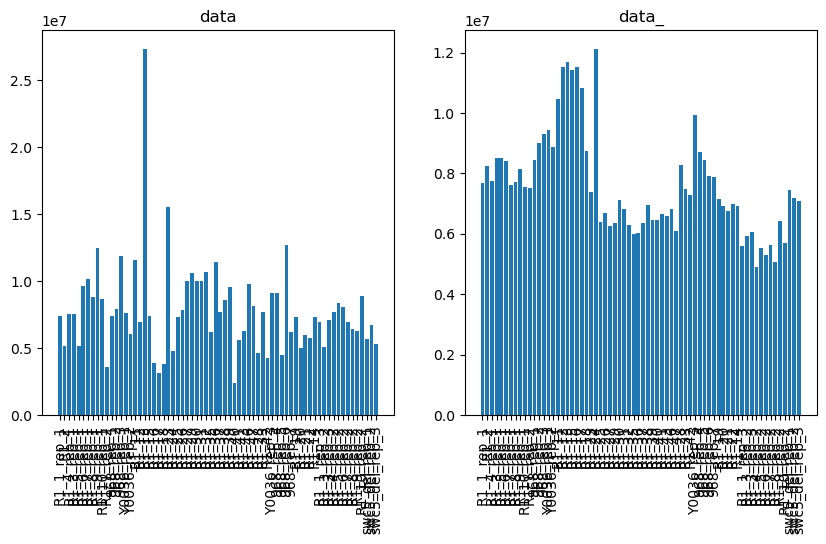

In [6]:
#plot the column totals in data and in data_
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(range(len(col_names)),np.sum(data,axis=0))
plt.xticks(range(len(col_names)),col_names,rotation=90)
plt.title('data')
plt.subplot(1,2,2)
plt.bar(range(len(col_names)),np.sum(data_,axis=0))
plt.xticks(range(len(col_names)),col_names,rotation=90)
plt.title('data_')
plt.show()


### Importing data on MLPs

In [7]:
#import washing phenotypes /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Celeste's original code/QTL mapping/washing_phenotypes.csv
washing = pd.read_csv(root + '/Bence folder/Phenotypes/phenotype_s.csv',header=0,index_col=0)
#keep first two cols
washing = washing.iloc[:,:2]
washing.columns = ['genotype','phenotype']
#import filtering phenotypes /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Celeste's original code/QTL mapping/filtering_phenotypes.csv
filtering = pd.read_csv(root + '/Celeste original code/QTL mapping/filtering_phenotypes.csv',header=0,index_col=0)
filtering.columns = ['genotype','phenotype']
#merge the two dataframes by genotype, and name the phenotypes washing and filtering
phenotypes = pd.merge(washing,filtering,on='genotype')
phenotypes.columns = ['genotype','washing','filtering']
#change entries with X968 to 968
phenotypes.loc[phenotypes.genotype=='X968','genotype'] = '968'

### Only keep RNA-seq data for strains that we have measurements on

In [8]:
#create an array called genotypes_to_retain, which has the entries from true_genotypes removing _rep_1 and _rep_2
genotypes_to_retain = [i.split('_rep_')[0] for i in true_genotypes]
#only retain the ones that are in the phenotypes dataframe
genotypes_to_retain = [i for i in genotypes_to_retain if i in phenotypes.genotype.values]
#subset col_names to include only the genotypes that are in genotypes_to_retain, or those + _rep_...
col_names_retained = [i for i in col_names if i in genotypes_to_retain or i.split('_rep_')[0] in genotypes_to_retain]
#index of which col_names were retained
ind = [i in col_names_retained for i in col_names]
#subset the data to only include the genotypes in genotypes_to_retain in the same order
data_full = data_.copy()
data_ = data_[:,ind]

In [9]:
data_ .shape

(6737, 65)

### Take mean of samples with multiple replicates

In [10]:
col_names_retained_wo_reps = [i.split('_rep_')[0] for i in col_names_retained]

#create a matrix of zeros with  dimensions: data.shape[0] and unique col_names_retained_wo_reps entries
data = np.zeros((data_.shape[0],len(np.unique(col_names_retained_wo_reps))))

for i,j in enumerate(np.unique(col_names_retained_wo_reps)):
    #find the indices of the columns in data_ that correspond to the genotype j

      ind = [k for k in range(len(col_names_retained)) if col_names_retained[k].split('_rep_')[0]==j]
      #take the mean of the columns in data_ that correspond to the genotype j
      data[:,i] = np.mean(data_[:,ind],axis=1)
final_cols = np.unique(col_names_retained_wo_reps)

### Create a DF with genotype and phenotype values in the same order as the samples in the RNA-seq dataset

In [11]:

#create a new df for phenotypes with reordering phenotypes such that genotype matches the order of those in col_names_retained_wo_reps
phenotypes_ = pd.DataFrame(columns=['genotype','washing','filtering'])
for i in final_cols:
    phenotypes_ = phenotypes_.append(phenotypes.loc[phenotypes.genotype==i,:])
phenotypes_.index = range(len(phenotypes_))
phenotypes_
#extract the two phenotypes as arrays from the df
washing = phenotypes_['washing'].values
filtering = phenotypes_['filtering'].values

### Perform correlation analysis between phenotypes and gene expression

In [12]:

def find_correlated_genes(data,phenotype, only_sig=True, add_function=True,systematic_names=systematic_names ):
    df = pd.DataFrame(columns=['gene','correlation','p-value'])
    with warnings.catch_warnings():
        for i in range(data.shape[0]):
            #create temp df with the gene expression and the phenotype df
            temp = pd.DataFrame({'gene':data[i,:],'phenotype':phenotypes_[phenotype], 'genotype':final_cols})
            
            cor = st.spearmanr(temp['gene'],temp['phenotype'])
            df = df.append({'gene':ind_names[i],'correlation':cor[0],'p-value':cor[1],"systematic_names":systematic_names[i]},ignore_index=True)
    #remove every row that has NaN for p-value
    df = df.dropna(subset=['p-value'])
    #perform BH correction

    df['p-value adj'] = smm.fdrcorrection(df['p-value'])[1]
    #order by p-value
    df = df.sort_values(by='p-value')
    #only retain significant ones
    if only_sig:
        df = df[df['p-value adj']<0.05]
    #for each gene add the function (column 4 in gene_desc)
    if add_function:
        #find the row in gene_desc where the gene name matches either the entry in column 0 or 2
        #add the function from column 4 to the df
        df['function'] = [gene_desc.loc[(gene_desc[0]==i) | (gene_desc[2]==i),4].to_string(index=False)  for i in df.gene]
        #if entry in function is 'Series([], )' then replace with 'unknown'
        df['function'] = [i if i!='Series([], )' else 'unknown' for i in df['function']]
        #if gene name has -antisense- in it, then look for what is after that, and see if it has a function
        #if it does, then add that function to the df
        df["sense function"] = df["function"]
        for i in range(df.shape[0]):
            if '-antisense-' in df.gene.values[i]:
                #find the gene name before -antisense-
                gene_name = df.gene.values[i].split('-antisense-')[0]
                #find the function of that gene
                function = gene_desc.loc[(gene_desc[0]==gene_name) | (gene_desc[2]==gene_name),4].to_string(index=False)
                #if the function is not 'Series([], )' then add it to the df
                if function!='Series([], )':
                    df['sense function'].values[i] = function
                else:
                    df['sense function'].values[i] = 'unknown'

    return df


In [13]:
with warnings.catch_warnings():
    wash_df = find_correlated_genes(data,"washing",only_sig=False)
    filt_df = find_correlated_genes(data,"filtering",only_sig=False)
#save these
wash_df.to_csv('wash_corr.csv')
#correlated with filter
filt_df.to_csv('filter_corr.csv')
    

### Plots for flocculation vs. gene expression

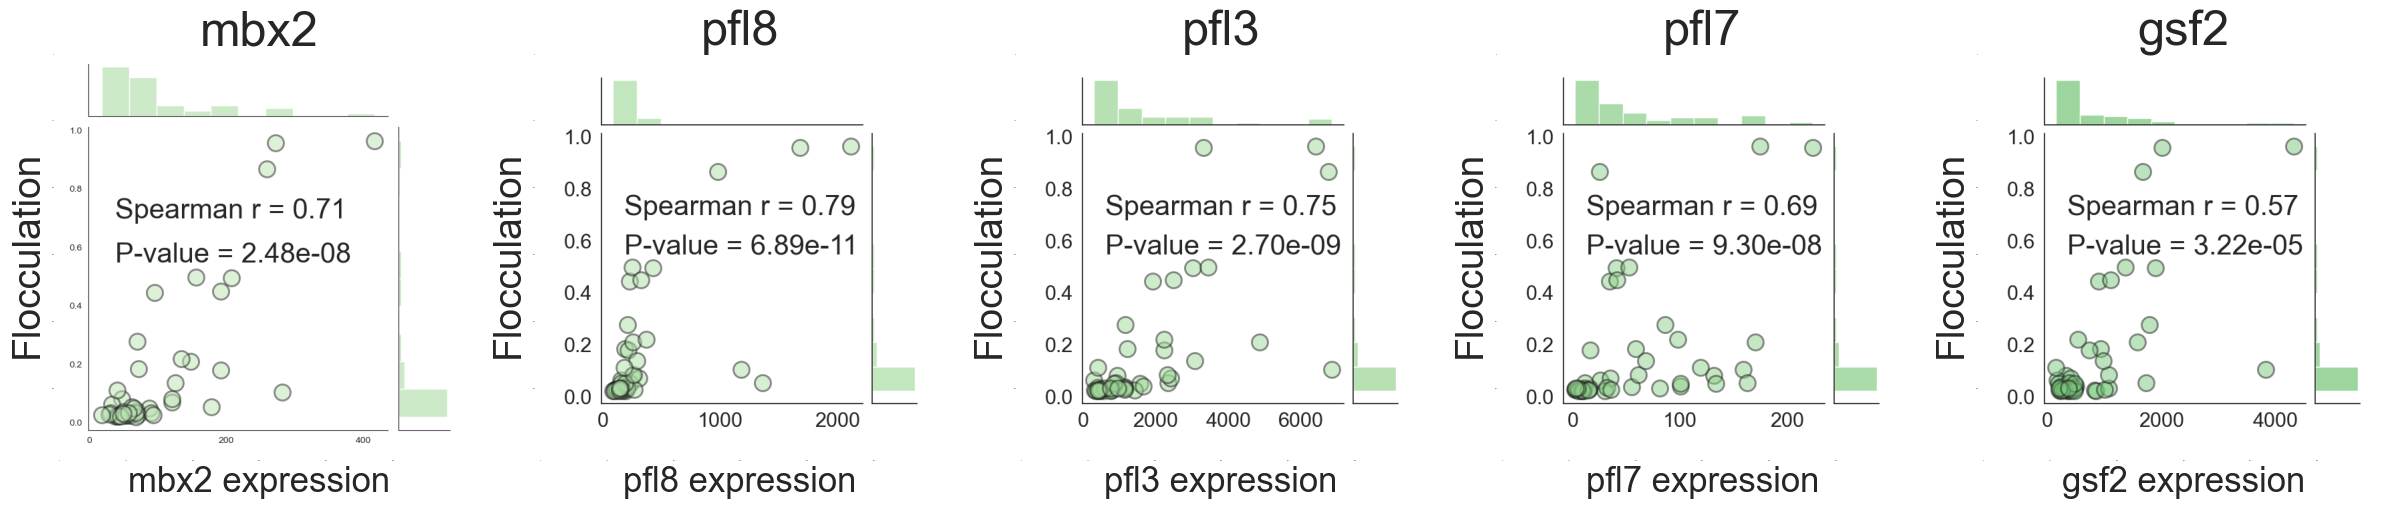

In [14]:
colors = sns.color_palette("Greens", 20)
#put 5 of these in a row by saving them as images and the using the image function in matplotlib
for i,j,col in zip(range(5),["mbx2","pfl8",  "pfl3","pfl7","gsf2"],colors[5:]):
    plt.figsize=(10,10)
    #large glyph with alpha transparency
    #strong thick edges for circles
    sns.set_style("white", {'axes.grid' : False})
    sns.despine()
    #fix 10 bins for the histogram
    sns.jointplot(data[ind_names==j,:][0],filtering,kind='scatter',color=col, alpha=0.5,s=300,edgecolor='k',linewidth=2, marginal_kws=dict(bins=10))
    #axis
    sns.set(font_scale=2)
    plt.xlabel('mbx2 expression level')
    #add p value
    #larger numbers next to the axis
    sns.set_style("white", {'axes.grid' : False})
    sns.despine()
    

#print corr coef
    plt.text(-190,0.7,'Spearman r = {:.2f}'.format(st.spearmanr(data[ind_names==j,:][0],filtering)[0]),fontsize=30)
    plt.text(-190,0.55,'P-value = {:.2e}'.format(st.spearmanr(data[ind_names==j,:][0],filtering)[1]),fontsize=30)
    plt.savefig('jointplot{}.png'.format(i))
    plt.close()
    
for i,j in zip(range(5),["mbx2","pfl8",  "pfl3","pfl7","gsf2"]):
    #load them and arange in one big plot
    
    plt.subplot(1,5,i+1)
    #read big figure
    plt.imshow(plt.imread('jointplot{}.png'.format(i)))
    #increase size
    plt.gcf().set_size_inches(30,30)
    plt.title(["mbx2","pfl8",  "pfl3","pfl7","gsf2"][i],fontsize=35)
    plt.axis('off')
    plt.axis('on')
    plt.ylabel('Flocculation',fontsize=28)
    plt.xlabel('{} expression'.format(j),fontsize=25)
    #remove ticks
    plt.tick_params(labelsize=0)
    #remove frame
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    #remove the ticks of the outer frame
    plt.gca().tick_params(axis='both', which='both', length=0)
  


### Plots for flocculins vs mbx2

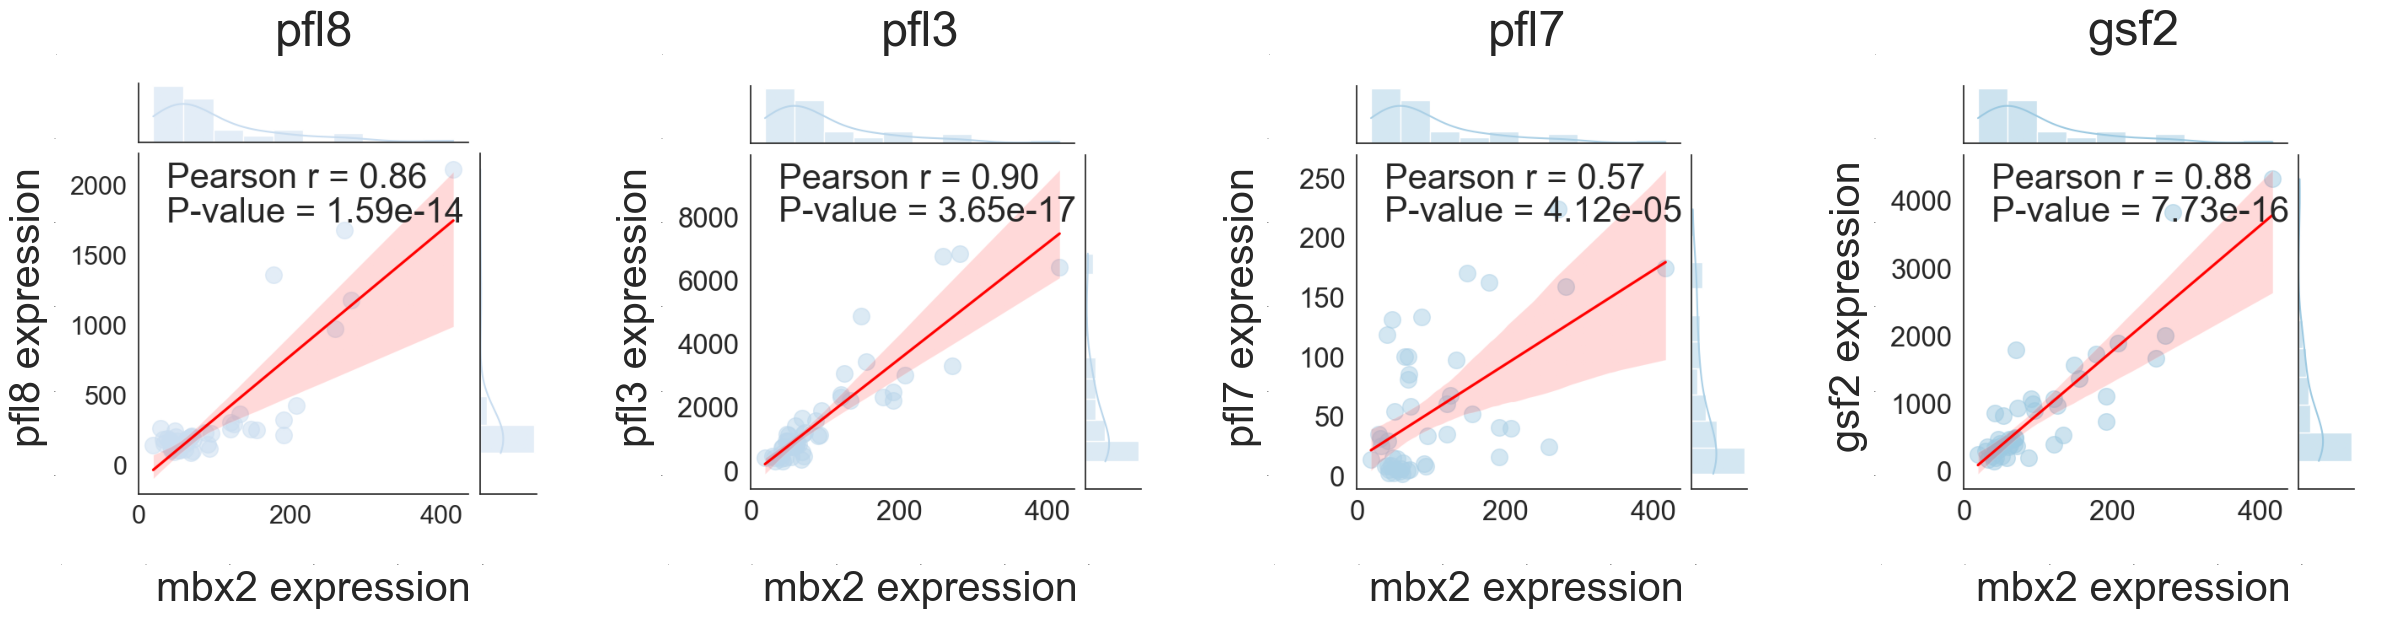

In [15]:
colors = sns.color_palette("Blues", 20)
#put 5 of these in a row by saving them as images and the using the image function in matplotlib
for i,j,col in zip(range(4),["pfl8",  "pfl3","pfl7","gsf2"],colors[4:]):
    plt.figsize=(10,10)
    sns.set_style("white", {'axes.grid' : False})
    sns.despine()
    #large glyph with alpha transparency
    sns.jointplot(data[ind_names=='mbx2',:][0],data[ind_names==j,:][0],kind='reg',color=col,joint_kws={'line_kws':{'color':'red'}},scatter_kws={'alpha':0.5,'s':200},marginal_kws=dict(bins=10))
    #axis
    plt.xlabel('mbx2 expression level')
    sns.set(font_scale=2.15)
    sns.set_style("white", {'axes.grid' : False})
    sns.despine()
    #add p value
    #larger numbers next to the axis
    

#print corr coef
    plt.text(-5.5,0.9,'Pearson r = {:.2f}'.format(st.pearsonr(data[ind_names==j,:][0],data[ind_names=='mbx2',:][0])[0]),transform=plt.gca().transAxes,fontsize=30)
    plt.text(-5.5,0.8,'P-value = {:.2e}'.format(st.pearsonr(data[ind_names==j,:][0],data[ind_names=='mbx2',:][0])[1]),transform=plt.gca().transAxes,fontsize=30)
    plt.ylabel('{} expression level'.format(j))
    plt.savefig('jointplot{}.png'.format(i))
    plt.close()
    
for i,j in zip(range(4),["pfl8",  "pfl3","pfl7","gsf2"]):
    #load them and arange in one big plot
    
    plt.subplot(1,4,i+1)
    #read big figure
    plt.imshow(plt.imread('jointplot{}.png'.format(i)))
    #increase size
    plt.gcf().set_size_inches(30,30)
    plt.title(["pfl8",  "pfl3","pfl7","gsf2"][i],fontsize=35)
    plt.axis('off')
    plt.axis('on')
    plt.xlabel('mbx2 expression',fontsize=30)
    plt.ylabel('{} expression'.format(j),fontsize=30)
    #remove ticks
    plt.tick_params(labelsize=0)
    #remove frame
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    #remove the ticks of the outer frame
    plt.gca().tick_params(axis='both', which='both', length=0)
    
    

### Perform differential expression analysis after splitting cells on the the srb11 mutation

In [51]:
#import /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/updated_genotype_matrix_final_pos.tsv
snps = pd.read_csv(root + "/internal data/updated_genotype_matrix_final_pos.tsv", sep="\t")

snps = snps[(snps["position"]==2316851)]
#remove first 4 columns
snps = snps.iloc[:,4:]

In [52]:

snps.reset_index(drop=True, inplace=True)
#snps now contains the genotypes at II:2316554
#remove columns with NaNs
for i in snps.columns:
    if (snps[i].isna().any()):
        snps = snps.drop(i,axis=1)

genotype = snps.loc[0].values
   
index_0= snps.columns[genotype==0]
colnames_0 = snps.columns[genotype==0]
index_1= snps.columns[genotype==1]
colnames_1 = snps.columns[genotype==1]
#iterate through enumerate col_names_retained_wo_reps and save the index of the column names in col_index_0 and col_index_1 deoendibgn on genotype
col_index_0 = []
col_index_1 = []
for i in enumerate(final_cols):
      if (i[1] in colnames_0):
            col_index_0.append(i[0])
      elif (i[1] in colnames_1):
            col_index_1.append(i[0])


In [32]:
df = pd.DataFrame(columns=["gene","mean_exp_0","mean_exp_1","log2fc","pval","pval_adjust"])
for i in ind_names:
    #get expression of gene i
      gene_exp = data[ind_names==i,:]
    
      gene_exp_0 = gene_exp[0,col_index_0]
      gene_exp_1 = gene_exp[0,col_index_1]


    #calculate mean expression of gene i for genotype 0
      mean_exp_0 = np.mean(gene_exp_0)
    #calculate mean expression of gene i for genotype 1
      mean_exp_1 = np.mean(gene_exp_1)
    #clculate log2fc
      log2fc = np.log2(mean_exp_1/mean_exp_0)
    #calculate pval
      pval = st.ttest_ind(gene_exp_0,gene_exp_1)[1]
      pval_adjust = pval*len(ind_names)
    #add to df
      df = df.append({"gene":i,"mean_exp_0":mean_exp_0,"mean_exp_1":mean_exp_1,"log2fc":log2fc,"pval":pval,"pval_adjust":pval_adjust},ignore_index=True)
      #print progress
      


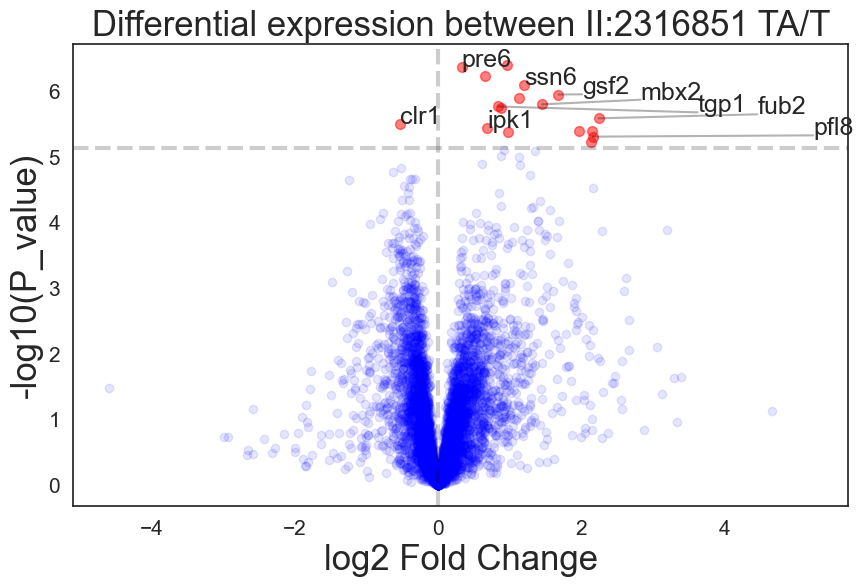

In [33]:
#sort based on pval_adjust
df = df.sort_values(by="pval_adjust")
df.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Differential expression between II:2316851 TA/T",fontsize=25)
ax.set_xlabel("log2 Fold Change",fontsize=25)
ax.set_ylabel("-log10(P_value)",fontsize=25)
for i in df.index:
      if (df.loc[i,"pval_adjust"]<0.05):
            ax.scatter(df.loc[i,"log2fc"],-np.log10(df.loc[i,"pval"]),c='red',alpha=0.5,s=50)
      else:
            ax.scatter(df.loc[i,"log2fc"],-np.log10(df.loc[i,"pval"]),c='blue',alpha=0.1)
#plot a horizontal line at -log10(0.05)
#bonferroni correction
bonf=0.05/len(df)
ax.axhline(y=-np.log10(bonf),color='black',linestyle='--', alpha=0.1, linewidth=3)

#plot a vertical line at log2fc=0
ax.axvline(x=0,color='black',linestyle='--', alpha=0.1, linewidth=3)
#plot a horizontal line at -log10(0.05)
ax.axhline(y=-np.log10(bonf),color='black',linestyle='--', alpha=0.1, linewidth=3)
#plot a vertical line at log2fc=0
ax.axvline(x=0,color='black',linestyle='--', alpha=0.1, linewidth=3)
#annotate top 10 genes with their names and make sure these dont overlap. To do this make a matrix of their coordinates and make sure they are far enough apart
matrix = np.zeros((20,2))

for k in range(20):
     
      x = df.loc[k,"log2fc"]
      y = -np.log10(df.loc[k,"pval"])
      
      while (np.min(np.sqrt((matrix[:,0]-x)**2+(matrix[:,1]-y)**2))<0.8):
            #random walk
            if x<0:
                  x = x + np.random.normal(-0.05,0.05)
            else:
                  x = x + np.random.normal(0.05,0.05)
            y = y + np.random.normal(0,0.05)
      
      #if df.loc[k,"gene"] is less than 5 characters long, annotate it 0.1 above the point
      if (len(df.loc[k,"gene"])<5):
            ax.annotate(df.loc[k,"gene"],(x,y),fontsize=18)
            ax.plot([x,df.loc[k,"log2fc"]],[y,-np.log10(df.loc[k,"pval"])],color='black',alpha=0.3)
      else:
            x=x+1000
            y=y+1000
      matrix[k,0] = x
      matrix[k,1] = y
#increase fontsize of axis labels and title
ax.tick_params(labelsize=15)

In [20]:
#save df as srb11_diff_exp.csv
#df.to_csv(root + "/internal data/srb11_diff_exp.csv")

### Saving results for Angeli and further analysis

In [21]:
#angeli for flocclation genes
filt_df_genes = filt_df[["systematic_names","p-value adj"]]
sig_genes = filt_df_genes[filt_df_genes["p-value adj"]<0.05]["systematic_names"].values
background_genes = filt_df_genes["systematic_names"].values
#export to this folder /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Angeli
sig_genes = pd.DataFrame(sig_genes)
sig_genes.to_csv(root + "/Bence folder/Angeli/sig_genes.csv",index=False)
background_genes = pd.DataFrame(background_genes)
background_genes.to_csv(root + "/Bence folder/Angeli/background_filt_genes.txt",index=False)

# Performing differential expression analysis on genes with srb11 and chrIII variant vs only srb11


In [105]:
#import /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/updated_genotype_matrix_final_pos.tsv
snps = pd.read_csv(root + "/internal data/updated_genotype_matrix_final_pos.tsv", sep="\t")
#position is [2316851,58868]
snps = snps[(snps["position"]==2316851) | (snps["position"]==47493)]
#remove first 4 columns
snps = snps.iloc[:,4:]
snps

,968,Y0036,R1_1,R1_2,R1_3,R1_5,R1_6,R1_7,R1_8,R1_10,...,R1_9,R1_34,R1_44,R1_49,R1_50,R1_51,R1_52,R1_53,R1_54,R1_4
2341,0,1.0,NaN,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0,1.0
3540,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


In [115]:

snps.reset_index(drop=True, inplace=True)
#snps now contains the genotypes at II:2316554
#remove columns with NaNs
for i in snps.columns:
    if (snps[i].isna().any()):
        snps = snps.drop(i,axis=1)

srb_genotype = snps.loc[0].values
chriii_genotype = snps.loc[1].values
   
srb_index_0= snps.columns[srb_genotype==0]
srb_colnames_0 = snps.columns[srb_genotype==0]

chriii_index_0= snps.columns[chriii_genotype==0]
chriii_colnames_0 = snps.columns[chriii_genotype==0]

srb_index_1= snps.columns[srb_genotype==1]
srb_colnames_1 = snps.columns[srb_genotype==1]

chriii_index_1= snps.columns[chriii_genotype==1]
chriii_colnames_1 = snps.columns[chriii_genotype==1]

#iterate through enumerate col_names_retained_wo_reps and save the index of the column names in col_index_0 and col_index_1 deoendibgn on genotype
srb_col_index_0 = []
srb_col_index_1 = []

chriii_col_index_0 = []
chriii_col_index_1 = []
for i in enumerate(final_cols):
        if (i[1] in srb_colnames_0):
            srb_col_index_0.append(i[0])
        if (i[1] in srb_colnames_1):
            srb_col_index_1.append(i[0])
        if (i[1] in chriii_colnames_0):
            chriii_col_index_0.append(i[0])
        if (i[1] in chriii_colnames_1):
            chriii_col_index_1.append(i[0])
           

In [122]:
df = pd.DataFrame(columns=["gene","mean_exp_0","mean_exp_1","log2fc","pval","pval_adjust"])
for i in ind_names:
    #get expression of gene i
        gene_exp = data[ind_names==i,:]
    #create four gene expression vectors for each genotype
    #first the intersection of srb_col_index_0 and chriii_col_index_0
        gene_exp_0 = gene_exp[0,np.intersect1d(srb_col_index_0,chriii_col_index_0)]
        gene_exp_1 = gene_exp[0,np.intersect1d(srb_col_index_0,chriii_col_index_1)]
        gene_exp_2 = gene_exp[0,np.intersect1d(srb_col_index_1,chriii_col_index_0)]
        gene_exp_3 = gene_exp[0,np.intersect1d(srb_col_index_1,chriii_col_index_1)]

    #calculate mean expression of gene i for genotype 0
        mean_exp_0 = np.mean(gene_exp_0)
    #calculate mean expression of gene i for genotype 1
        mean_exp_1 = np.mean(gene_exp_1)
    #calculate mean expression of gene i for genotype 2
        mean_exp_2 = np.mean(gene_exp_2)
    #calculate mean expression of gene i for genotype 3
        mean_exp_3 = np.mean(gene_exp_3)
    #clculate log2fc
        log2fc = np.log2(mean_exp_3/mean_exp_2)
    #calculate pval
        pval = st.ttest_ind(gene_exp_2,gene_exp_3)[1]
        pval_adjust = pval*len(ind_names)
    #add to df
        df = df.append({"gene":i,"mean_exp_0":mean_exp_0,"mean_exp_1":mean_exp_1,"mean_exp_2":mean_exp_2,"mean_exp_3":mean_exp_3,"log2fc":log2fc,"pval":pval,"pval_adjust":pval_adjust},ignore_index=True)

df = df.sort_values(by="pval_adjust")
df.reset_index(drop=True, inplace=True)

In [125]:
#df find gene SPCP20C8.02c
df.head(50)

,gene,mean_exp_0,mean_exp_1,log2fc,pval,pval_adjust,mean_exp_2,mean_exp_3
0,gyp3,841.051622,865.600428,0.271141,0.002236,15.063337,770.287350,929.553590
1,vac14,265.970560,269.567787,0.475198,0.003400,22.905306,175.376353,243.792182
2,rpl2702-antisense-1,5.829518,5.328297,-1.574707,0.004492,30.262783,8.026525,2.694595
3,SPBP23A10.17,68.827294,62.227853,0.489697,0.005275,35.535187,47.699304,66.976972
4,SPNCRNA.1130,30.797567,26.182147,-0.892500,0.006180,41.635586,25.975805,13.992642
5,apm4,303.279403,314.456960,-0.196323,0.007327,49.362171,281.139085,245.370373
6,mbx2,66.919690,73.471210,1.291962,0.007373,49.673394,109.947025,269.217144
7,taf4,425.875633,413.399192,0.329092,0.007744,52.173985,330.989023,415.795827
8,met7,741.235944,729.936708,0.382536,0.007796,52.521006,601.484339,784.113817
9,slm5,186.457674,203.150989,0.571614,0.007956,53.602420,149.044627,221.507956


KeyboardInterrupt: 

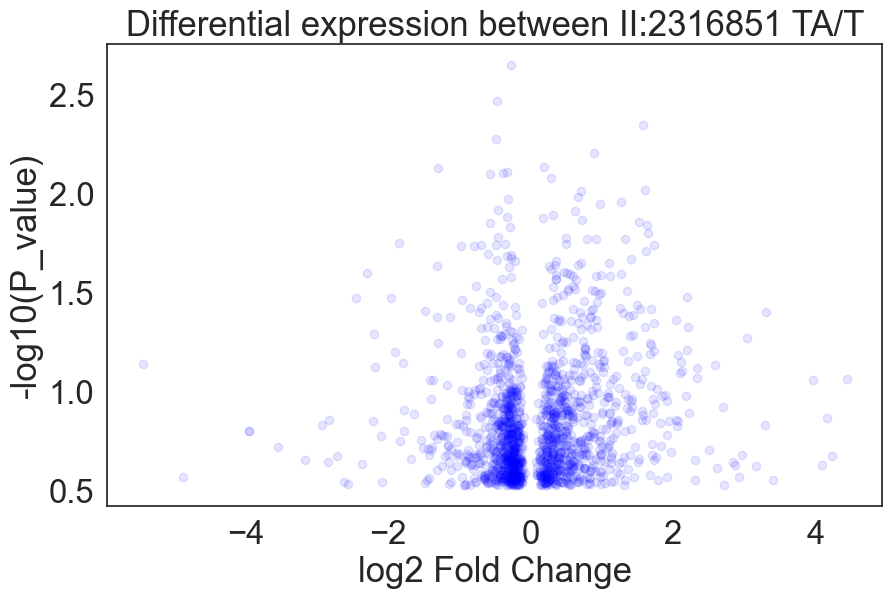

In [66]:


fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Differential expression between II:2316851 TA/T",fontsize=25)
ax.set_xlabel("log2 Fold Change",fontsize=25)
ax.set_ylabel("-log10(P_value)",fontsize=25)
for i in df.index:
      if (df.loc[i,"pval_adjust"]<0.05):
            ax.scatter(df.loc[i,"log2fc"],-np.log10(df.loc[i,"pval"]),c='red',alpha=0.5,s=50)
      else:
            ax.scatter(df.loc[i,"log2fc"],-np.log10(df.loc[i,"pval"]),c='blue',alpha=0.1)
#plot a horizontal line at -log10(0.05)
#bonferroni correction
bonf=0.05/len(df)
ax.axhline(y=-np.log10(bonf),color='black',linestyle='--', alpha=0.1, linewidth=3)

#plot a vertical line at log2fc=0
ax.axvline(x=0,color='black',linestyle='--', alpha=0.1, linewidth=3)
#plot a horizontal line at -log10(0.05)
ax.axhline(y=-np.log10(bonf),color='black',linestyle='--', alpha=0.1, linewidth=3)
#plot a vertical line at log2fc=0
ax.axvline(x=0,color='black',linestyle='--', alpha=0.1, linewidth=3)
#annotate top 10 genes with their names and make sure these dont overlap. To do this make a matrix of their coordinates and make sure they are far enough apart
matrix = np.zeros((20,2))

for k in range(20):
     
      x = df.loc[k,"log2fc"]
      y = -np.log10(df.loc[k,"pval"])
      
      while (np.min(np.sqrt((matrix[:,0]-x)**2+(matrix[:,1]-y)**2))<0.8):
            #random walk
            if x<0:
                  x = x + np.random.normal(-0.05,0.05)
            else:
                  x = x + np.random.normal(0.05,0.05)
            y = y + np.random.normal(0,0.05)
      
      #if df.loc[k,"gene"] is less than 5 characters long, annotate it 0.1 above the point
      if (len(df.loc[k,"gene"])<5):
            ax.annotate(df.loc[k,"gene"],(x,y),fontsize=18)
            ax.plot([x,df.loc[k,"log2fc"]],[y,-np.log10(df.loc[k,"pval"])],color='black',alpha=0.3)
      else:
            x=x+1000
            y=y+1000
      matrix[k,0] = x
      matrix[k,1] = y
#increase fontsize of axis labels and title
ax.tick_params(labelsize=15)

### All used packages


In [22]:
%load_ext watermark
%watermark -v -p numpy,pandas,scipy,matplotlib,seaborn,statsmodels

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.31.1

numpy      : 1.21.6
pandas     : 1.4.4
scipy      : 1.7.3
matplotlib : 3.4.3
seaborn    : 0.11.2
statsmodels: 0.13.5

